**CS577 Deep Learning Project** \
**Topic** : BirdCaps : Bird species classification using Capsule Networks \
**Team Members** :- \
Yash Pradeep Gupte - A20472798 \
Namita Sandeep Tambe - A20460837 \

**Main code**

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1aa97ed3-0560-40fc-9ea2-dcc4972f3649)


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue May  4 23:50:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#Mount Drive 
import os

# Mount drive if not mounted already & change current working directory to MyDrive
if not os.path.exists('/content/drive/'):
  from google.colab import drive
  drive.mount('/content/drive/')

if os.path.exists('/content/drive'):
  os.chdir('drive/My Drive')
  print('Current working directory:', os.getcwd())

Mounted at /content/drive/
Current working directory: /content/drive/My Drive


In [5]:
cd CS577_DeepLearning/Project/

/content/drive/My Drive/CS577_DeepLearning/Project


In [6]:
ls

entire_dataset/  images/  images_details.txt  models/  test/  train/


In [7]:
#Import Libraries

#Sys and helpers
import os
import pickle #JSON Serialization & DeSerialization
import time
import pandas as pd

#Math Libraries
import numpy as np
import random
import math

#ML Libraries
import tensorflow as tf
from keras import Input, Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, concatenate, Flatten, Lambda, Concatenate, Multiply, MaxPooling2D , Dropout
from keras.optimizers import Adam, RMSprop, SGD
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.models import load_model , save_model

from sklearn.model_selection import  train_test_split
from keras.utils import to_categorical
from keras.models import load_model
import string 

#Visualization
import PIL
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm as tqdm
%matplotlib inline

print('Modules Imported')

Modules Imported


**Data Loading**

In [8]:
#Loading Preprocessed and Augmented dataset : final_augmented_dataset_updated_labels0to14.pickle
with open('/content/drive/My Drive/CS577_DeepLearning/Project/entire_dataset/final_augmented_dataset_updated_labels0to14.pickle' , 'rb') as f:
      final_augmented_dataset = pickle.load(f, encoding='latin1')

In [9]:
#Split X_data - image array and y_lables - class labels
X_data = np.array([i[0] for i in final_augmented_dataset])
y_labels = np.array([i[1] for i in final_augmented_dataset])

print(X_data.shape)
print(y_labels.shape)

(56892, 64, 64, 3)
(56892,)


In [10]:
y_labels = to_categorical(y_labels)

In [11]:
print(y_labels.shape)

(56892, 15)


In [12]:
print(y_labels[0])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [13]:
x_train, x_test, y_train , y_test  = train_test_split(X_data, y_labels, test_size = 0.2 , shuffle = True)

In [14]:
print(x_test.shape)

(11379, 64, 64, 3)


In [15]:
#Split train into validation set and train sets
x_val = x_train[:11379]
y_val = y_train[:11379]

x_train_new = x_train[11379:]
y_train_new = y_train[11379:]


In [16]:
print("Train data:")
print(x_train_new.shape)
print(y_train_new.shape)

print("\nValidation data : ")
print(x_val.shape)
print(y_val.shape)

print("\nTest data: ")
print(x_test.shape)
print(y_test.shape)

Train data:
(34134, 64, 64, 3)
(34134, 15)

Validation data : 
(11379, 64, 64, 3)
(11379, 15)

Test data: 
(11379, 64, 64, 3)
(11379, 15)


**Capsule Networks Model**

In [17]:
def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

In [18]:
def build_capsule_model():
  input_layer = Input(shape=(64, 64, 3))

  # First Convolutional Layer of the Capsule Architecture
  x = Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', name='Conv_layer_1')(input_layer)
  x = LeakyReLU()(x)
  
  # Bach Normaliation layer 
  x = BatchNormalization(momentum=0.8)(x)

  # Primary Capsule layer with 8 vectors * 32 channels = 256 filters
  x = Conv2D(filters=8 * 32, kernel_size=9, strides=2, padding='valid', name='Primarycaps_conv_layer_2')(x)

  # Reshaping the  8D vector for all 32 feature maps
  x = Reshape(target_shape=[-1, 8], name='reshape_primarycap')(x)
  
  
  # Use the quash function to squash the values between 0 and 1  
  x = Lambda(squash, name='squash_primarycaps')(x)
  x = BatchNormalization(momentum=0.8)(x)

  x = Flatten()(x)

  #u_hat is multiplication of prediction vector and Weight matrix . Num of capsules = 15 and Number of vectors  = 16
  u_hat = Dense(15*16, kernel_initializer='he_normal', bias_initializer='zeros', name='u_hat')(x)

  # c is the coupling coefficient whiich is basically a softmax over the previous dense layer
  c = Activation('softmax', name='softmax1')(u_hat) 
  
  # s_j is output of current capsule layer that is (u_hat * c)
  c = Dense(240)(c) 
  x = Multiply()([u_hat, c])
  s_j = LeakyReLU()(x)

  c = Activation('softmax', name='softmax2')(s_j) 
  x = Multiply()([u_hat, c])
  s_j = LeakyReLU()(x)

  c = Activation('softmax', name='softmax3')(s_j) 
  c = Dense(240)(c) 
  x = Multiply()([u_hat, c])
  s_j = LeakyReLU()(x)

  #We have executed the above dynamic routing 3 times

  cap_pred = Dense(15, activation='softmax')(s_j)

  capsule_cls_model = Model(inputs=input_layer, outputs=[cap_pred])

  print(capsule_cls_model.summary())

  return capsule_cls_model

In [19]:
 # build a basic CNN model for comparision
 def build_cnn_model():
  inputShape = Input((64,64,3))

  x = Conv2D(64,(3,3),padding='same',activation='relu')(inputShape)
  x = MaxPooling2D((2,2))(x)
  x = Dropout(0.5)(x)

  x = Conv2D(32,(3,3),padding='same',activation='relu')(x)
  x = MaxPooling2D((2,2))(x)
  x = Dropout(0.5)(x) 


  x = Conv2D(32,(3,3),padding='same',activation='relu')(x)
  x = MaxPooling2D((2,2))(x)
  x = Dropout(0.5)(x)

  x = Conv2D(16,(3,3),padding='same',activation='relu')(x)
  x = MaxPooling2D((2,2))(x)
  x = Dropout(0.5)(x)


  x = Flatten()(x)
  x = Dense(512, activation='relu')(x)
  outputShape = Dense(15,activation='softmax')(x)

  cnn_model = Model(inputs = inputShape , outputs = outputShape)
  print(cnn_model.summary())

  return cnn_model 

In [20]:
#Build and Compile / Load Capsule networks model
image_size = 64
batch_size = 64

print("Train data is loaded")


print("Test data is loaded")
print("dataset loaded completely")

if os.path.exists('./models/capsule_cls_model.h5'):
  print("Model exits")
  capsule_cls_model = build_capsule_model()
  capsule_cls_model = load_model('./models/capsule_cls_model.h5')

else :
  print("Models does not exists")
  capsule_cls_model = build_capsule_model()
  capsule_cls_model.compile(optimizer= Adam(lr = 0.0001),loss='categorical_crossentropy', metrics = ['accuracy']) #Model 1. : Adam(lr = 0.0001) , Model 2 : Adam(lr = 0.0002, beta_1=0.5, beta_2=0.999) 





Train data is loaded
Test data is loaded
dataset loaded completely
Model exits
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Conv_layer_1 (Conv2D)           (None, 56, 56, 256)  62464       input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 56, 56, 256)  0           Conv_layer_1[0][0]               
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 56, 56, 256)  1024        leaky_re_lu[0][0]                
_______________

In [ ]:
history_caps = capsule_cls_model.fit(x_train_new ,y_train_new , validation_data= (x_val , y_val) ,epochs =10 , batch_size= 64) 

In [28]:
#Compile or Load the CNN model

if os.path.exists('./models/cnn_model.h5'):
  print("Model exits")
  cnn_model = build_cnn_model()
  cnn_model = load_model('./models/cnn_model.h5')

else :
  print("Models does not exists")
  cnn_model = build_cnn_model()
  cnn_model.compile(optimizer= Adam(lr = 0.0001),loss='categorical_crossentropy', metrics = ['accuracy']) #Model 1. : Adam(lr = 0.0001) , Model 2 : Adam(lr = 0.0002, beta_1=0.5, beta_2=0.999) 


Model exits
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)

In [ ]:
history_cnn = cnn_model.fit(x_train_new ,y_train_new , validation_data= (x_val , y_val) ,epochs =100 , batch_size= 64) 

In [ ]:
#save cnn model
cnn_model.save("./models/cnn_model.h5")

Text(0.5, 1.0, 'Image 6')

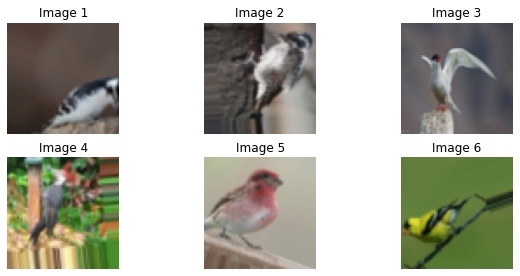

In [22]:
rows = 3
columns = 3
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(rows, columns, 1)
plt.imshow(x_test[45])
plt.axis('off')
plt.title("Image 1")


fig.add_subplot(rows, columns, 2)
plt.imshow(x_test[60])
plt.axis('off')
plt.title("Image 2")


fig.add_subplot(rows, columns, 3)
plt.imshow(x_test[8423])
plt.axis('off')
plt.title("Image 3")


fig.add_subplot(rows, columns, 4)
plt.imshow(x_test[11])
plt.axis('off')
plt.title("Image 4")


fig.add_subplot(rows, columns, 5)
plt.imshow(x_test[1204])
plt.axis('off')
plt.title("Image 5")

fig.add_subplot(rows, columns, 6)
plt.imshow(x_test[5623])
plt.axis('off')
plt.title("Image 6")




In [23]:
#print(y_test[45])
print("Actual Labels")
print("Image 1 label :", np.argmax(y_test[45])+1) 
print("Image 2 label :", np.argmax(y_test[60])+1) 
print("Image 3 label: ", np.argmax(y_test[8423])+1) 
print("Image 4 label: ", np.argmax(y_test[11])+1)
print("Image 5 label: ", np.argmax(y_test[1204])+1)
print("Image 6 label: ", np.argmax(y_test[5623])+1)

Actual Labels
Image 1 label : 14
Image 2 label : 14
Image 3 label:  11
Image 4 label:  14
Image 5 label:  2
Image 6 label:  2


In [24]:
# Make a prediction using capsule model
pred1 = capsule_cls_model.predict(x_test[45:46])
pred2 = capsule_cls_model.predict(x_test[60:61])
pred3 = capsule_cls_model.predict(x_test[8423:8424])
pred4 = capsule_cls_model.predict(x_test[11:12])
pred5 = capsule_cls_model.predict(x_test[1204:1205])
pred6 = capsule_cls_model.predict(x_test[5623:5624])
#print("Predictions vector : ",pred)
print("Predicted Class labels :")

print("Image 1 predicted label:", np.argmax(pred1)+1 )
print("Image 2 predicted label:", np.argmax(pred2)+1)
print("Image 3 predicted label:", np.argmax(pred3)+1)
print("Image 4 predicted label:", np.argmax(pred4)+1)
print("Image 5 predicted label:", np.argmax(pred5)+1)
print("Image 6 predicted label:", np.argmax(pred6)+1)

Predicted Class labels :
Image 1 predicted label: 14
Image 2 predicted label: 14
Image 3 predicted label: 11
Image 4 predicted label: 2
Image 5 predicted label: 2
Image 6 predicted label: 2


In [25]:
#Evaluate test set using capsule model
eval_test = capsule_cls_model.evaluate(x_test, y_test, batch_size=64)

178/178 [==============================] - 18s 69ms/step - loss: 0.3695 - accuracy: 0.9090


In [ ]:
#save capsule model
capsule_cls_model.save("./models/capsule_cls_model.h5")

In [29]:
# Make a prediction using CNN model
cnn_pred1 = cnn_model.predict(x_test[45:46])
cnn_pred2 = cnn_model.predict(x_test[60:61])
cnn_pred3 = cnn_model.predict(x_test[8423:8424])
cnn_pred4 = cnn_model.predict(x_test[11:12])
cnn_pred5 = cnn_model.predict(x_test[1204:1205])
cnn_pred6 = cnn_model.predict(x_test[5623:5624])
#print("Predictions vector : ",pred)
print("Predicted Class labels :")

print("Image 1 predicted label:", np.argmax(cnn_pred1)+1 )
print("Image 2 predicted label:", np.argmax(cnn_pred2)+1)
print("Image 3 predicted label:", np.argmax(cnn_pred3)+1)
print("Image 4 predicted label:", np.argmax(cnn_pred4)+1)
print("Image 5 predicted label:", np.argmax(cnn_pred5)+1)
print("Image 6 predicted label:", np.argmax(cnn_pred6)+1)

Predicted Class labels :
Image 1 predicted label: 6
Image 2 predicted label: 15
Image 3 predicted label: 11
Image 4 predicted label: 14
Image 5 predicted label: 2
Image 6 predicted label: 12


In [30]:
#Evaluate test set using CNN model
cnn_eval_test = cnn_model.evaluate(x_test, y_test, batch_size=64)

178/178 [==============================] - 1s 4ms/step - loss: 1.0220 - accuracy: 0.6442
